# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Project Name
Project mentor: Guanghui Qin

Shreya Wadhwa  <swadhwa5@jh.edu>, Alan Zhang  <azhang42@jh.edu>, Aidan Aug  <aaug1@jh.edu>, Trisha Karani <tkarani1@jh.edu>

https://github.com/swadhwa5/MLfinalproject

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. Create and compare at least two models with differing feature extraction techniques or network architectures: As of now, we have only completed LeNet(this can be changed once we complete AlexNet)
2. Identify potential themes/ image features common among misclassifications in our model (this can also be changed?)
3. Create a majority vote classifier with multiple model types and parameters
4. Augment our model by including a broader dataset with sign-language words for model training instead of just letters and digits: We found that it would be wise to first implement a high performance model just on ASL letters before extending to words and digits.


### Completed Deliverables
1. Model with classification accuracy of 50%: We achieved 87% accuracy with our LeNet Model
2. Model with classification accuracy of 80%: We achieved 87% accuracy with our LeNet Model
3. Identify 5 important data augmentation methods in sign-language classification: We applied various transformations to our images such as Normalize, Reshape, Blur, Vertical Flip, Translation, Scale, and Rotation, examples of which are shown in the Pre-Processing section. 
4. Identity transformations on our data that would not retain accuracy: We identified that testing on our Mult_Augment images, which have more than 1 augmentation on each image decreased the accuracy of our model significantly


### Additional Deliverables
N.A.

# Preliminaries

## What problem were you trying to solve or understand?

#### What are the real-world implications of this data and task?

The ability to communicate using ASL can increase awareness about the hard of hearing community. We want to explore the area of sign language translation: how people who might not be immediately fluent with ASL can communicate with people who rely on sign language. We aim to build a model that can return the alphabet corresponding to the hand gesture as seen in any image. Thus, the input to our algorithm will be images of hand configurations of ASL letters.

#### How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?

This is a supervised classification problem, which is similar to HW3 where we were given fruit images with labels and we were supposed to build different models to classify each fruit image to it's correct label.

#### What makes this problem unique?

There has been a lot of discussion about being more inclusive towards the hard of hearing community by encouraging more people to learn ASL, but few about how we can make use to ML to facilitate the ability to do the same without having to learn the ASL in its entirety.

#### What ethical implications does this problem have?

There are no significant ethical implications to this problem, but in the future we would like to add hand images with different complexities to remove any bias on the bases of race. 


## Dataset(s)

#### Describe the dataset(s) you used. How were they collected?

The dataset images were taken by a team from Massey University. The images are solely hands making a ASL sign with a black background. The images range in size from 200-500 pixels per side. 

The link for the dataset can be found here: https://www.massey.ac.nz/~albarcza/gesture_dataset2012.html

#### Why did you choose them?

We chose this dataset because the images are very clear, well structured and seem like a good fit for our project.

#### How many examples in each?

We used a 650 image subset of the dataset, with 25 images per letter, corresponding to 650 images in total.

In [4]:
from os import listdir
import imghdr
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

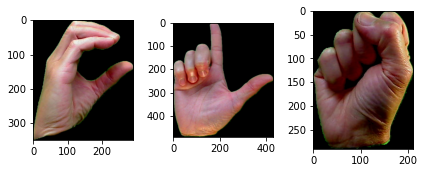

In [5]:


# Load your data and print 2-3 examples
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList:
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # only add 5 of each image, only add alphabetical values
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels

path = "./handgesturedataset_part1/"
imgs, labels = loadImages(path)

indices = (np.random.rand(3) * 650).astype(int)

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imgs[indices[i]])
plt.tight_layout()


## Pre-processing

#### What features did you use or choose not to use? Why?

In addition to the image feature, we used 4 additional features: The coordinates of the convex hull, coordinates of the alphashape, ratio of the two, and finally the ratio of hand to background. We hoped that these features would lend themselves to discovering how many fingers are help up. For example, a closed fist is more convex, and occupies less area compared to a hand that has a few fingers out.

#### If you have categorical labels, were your datasets class-balanced?

Yes, our dataset was balanced, with 25 images per label.

#### How did you deal with missing data? What about outliers?

There was no missing data or outliers

#### What approach(es) did you use to pre-process your data? Why?

We chose to resize the data into 32x32 squares and we also normalized the images. Doing these made it easier to feed into our neural net. Additionally, they made it easier to apply our data augmentations.

#### Are your features continuous or categorical? How do you treat these features differently?

The ratios are continuous, while the coordinates are categorical. We did not do anything different.

In [6]:
import torchvision
import torchvision.transforms as transforms
import cv2
import alphashape
from descartes import PolygonPatch

convexity for image 1 is 0.9754500818330606
convexity for image 2 is 0.9244992295839753
convexity for image 3 is 0.9784366576819407


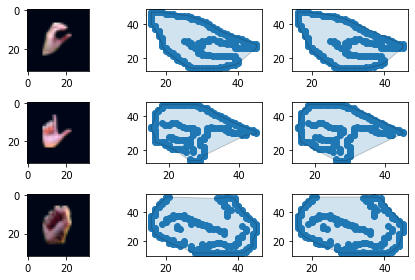

In [31]:
# For those same examples above, what do they look like after being pre-processed?
def applyTransforms(imgs, crop_size, resize):
    # Define the necessary preprocessing transforms
    num_imgs = len(imgs)
    preprocess = transforms.Compose([
        transforms.Resize(resize),  # Hyperparameter
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
    ])

    # Create tensor array
    transforms_array = np.zeros((num_imgs, 3, crop_size, crop_size))
    for i in range(num_imgs):
        temp = preprocess(imgs[i])
        transforms_array[i, :, :, :] = temp

    return transforms_array
transforms_array = applyTransforms(imgs, crop_size=32, resize=15)

for i in range(3):
    cur = transforms_array[indices[i]]
    out = np.empty((32, 32, 3))
    for z, a in enumerate(cur):
        for j, b in enumerate(a):
            for k, c in enumerate(b):
                out[j][k][z] = c
    orig = cv2.normalize(out, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    plt.subplot(3, 3, 1 + i * 3)
    plt.imshow(orig)
    
    orig = cv2.resize(orig, (64, 64), interpolation = cv2.INTER_AREA)

    edges = cv2.Canny(orig,250,300)

    contours, _ = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    contours = np.concatenate(contours)
    contours = contours.reshape((contours.shape[0], contours.shape[2]))

    alpha = alphashape.alphashape(contours, .07)
    x, y = alpha.exterior.coords.xy
    alphaPoints = np.column_stack((x, y))

    convex = alphashape.alphashape(contours, 0.)
    x, y = convex.exterior.coords.xy
    convexPoints = np.column_stack((x, y))
    
    ax = plt.subplot(3, 3, 2 + i * 3)
    ax.scatter(*zip(*contours))
    ax.add_patch(PolygonPatch(alpha, alpha=0.2))

    ax = plt.subplot(3, 3, 3 + i * 3)
    ax.scatter(*zip(*contours))
    ax.add_patch(PolygonPatch(convex, alpha=0.2))
    print('convexity for image', i + 1, 'is', alpha.area / convex.area)
plt.tight_layout()


In [ ]:
# Visualize the distribution of your data before and after pre-processing.
#   You may borrow from how we visualized data in the Lab homeworks.

## Augmentation

We also Augmented our images by applying transformations such as Blur, Scale, Rotate, Vertical Flip and Translation. As you will see in later sections, for the purposes of training and testing our model, we used 3 different datasets. 
1. handgesturesdataset_part1: Examples are shown in Dataset section
2. FinalImages
3. Mult_Augments

## FinalImages

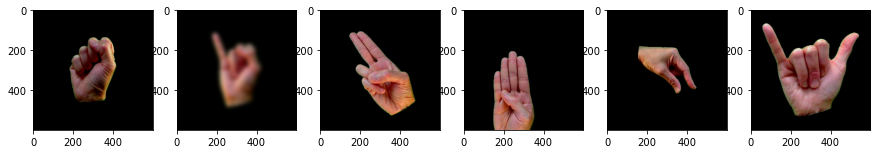

In [16]:
path = "./FinalImages/"
imgs, labels = loadImages(path)
fig, ax = plt.subplots(1, 6, figsize=(15,10))
ax[0].imshow(imgs[2]) #reshape
ax[1].imshow(imgs[1]) #blur
ax[2].imshow(imgs[3]) #rotate
ax[3].imshow(imgs[13]) #translation
ax[4].imshow(imgs[12]) #flip
ax[5].imshow(imgs[11]) #scale

## Mult_Augments

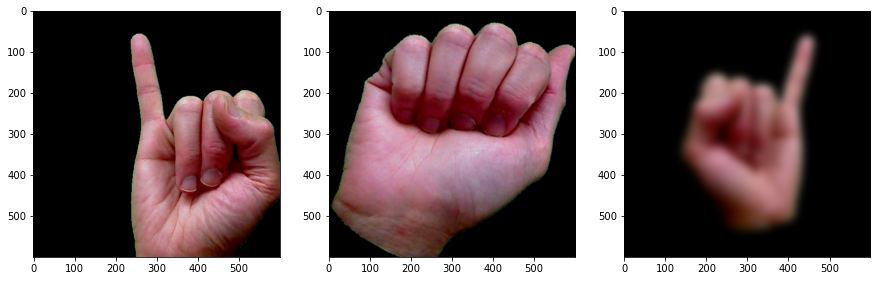

In [43]:
path = "./Mult_Augments/"
imgs, labels = loadImages(path)
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(imgs[8]) #scale + translate
ax[1].imshow(imgs[18]) #scale + rotate
ax[2].imshow(imgs[6]) #blur + flip

# Models and Evaluation

## Experimental Setup

How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?

What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?

How did you split your data into train and test sets? Why?


In [ ]:
# Code for loss functions, evaluation metrics or link to Git repo

## Baselines 

What baselines did you compare against? Why are these reasonable?

Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do?

## Methods

What methods did you choose? Why did you choose them?

How did you train these methods, and how did you evaluate them? Why?

Which methods were easy/difficult to implement and train? Why?

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

In [ ]:
# Code for training models, or link to your Git repository

In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.

## Results

Show tables comparing your methods to the baselines.

What about these results surprised you? Why?

Did your models over- or under-fit? How can you tell? What did you do to address these issues?

What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  

In [ ]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

What concepts from lecture/breakout were most relevant to your project? How so?

What aspects of your project did you find most surprising?

What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?

What was the most helpful feedback you received during your presentation? Why?

If you had two more weeks to work on this project, what would you do next? Why?